In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import dask.array as da
from distributed import Client
from fish.image.zds import ZDS
from os import makedirs
from os.path import exists
from functools import partial
from scipy.ndimage.filters import median_filter
from fish.util.distributed import get_jobqueue_cluster
from dask.array import coarsen
from skimage.io import imsave
import time

In [45]:
base_dirs = ('/nrs/ahrens/Yu/SPIM/active_dataset/20181125/fish1/20181125_1_1_gfaprgeco_OGB_5N_6dpf_singleplane_20181125_173551/',
             '/nrs/ahrens/Yu/SPIM/active_dataset/20181125/fish1/20181125_1_2_gfaprgeco_OGB_5N_6dpf_singleplane_25hz_20181125_180852/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/20181125/fish1/20181125_1_3_gfaprgeco_OGB_5N_6dpf_singleplane_25hz_20181125_183338/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/20181125/fish1/20181125_1_4_gfaprgeco_OGB_5N_6dpf_singleplane_volume_2Hz_20181125_190643/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181128/fish1/20181128_1_2_dbhgal4_uascochr_gfaprgeco_4dpf_stimMO_20181128_154713/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181128/fish1/20181128_1_4_dbhgal4_uascochr_gfaprgeco_4dpf_stimMO_afterpuffAPVNBQX_20181128_165722/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181128/fish1/20181128_1_6_dbhgal5_uascochr_gfaprgeco_4dpf_stimMO_after2ndpuffAPVNBQX_20181128_185903/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181128/fish2/20181128_2_4_dbhgal5_uascochr_gfaprgeco_4dpf_beforepuff_20181128_215816/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181128/fish2/20181128_2_6_dbhgal5_uascochr_gfaprgeco_4dpf_afterpuff_20181128_223045/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181128/fish2/20181128_2_7_dbhgal5_uascochr_gfaprgeco_4dpf_afterpuff_20181128_230431/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181129/fish1/20181129_1_2_dbhgal5_uascochr_gfaprgeco_5dpf_stim_beforepuff_20181129_135911/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181129/fish1/20181129_1_4_dbhgal5_uascochr_gfaprgeco_5dpf_stimMO_afterpuff_20181129_144050/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181129/fish2/20181129_2_4_dbhgal5_uascochr_gfaprgeco_5dpf_MO_befoerpuff_20181129_170747/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181129/fish2/20181129_2_6_dbhgal5_uascochr_gfaprgeco_5dpf_MO_afterpuff_20181129_175624/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181130/fish2/20181130_2_2_dbhgal4_uascochr_gfaprgeco_6dpf_MO_pairSwim_20181130_205704/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181130/fish2/20181130_2_4_dbhgal4_uascochr_gfaprgeco_6dpf_MO_pairSwim_20181130_221617/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181130/fish3/20181130_3_2_dbhgal4_uascochr_gfaprgeco_6dpf_MO_stim_20181201_003220/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181130/fish3/20181130_3_4_dbhgal4_uascochr_gfaprgeco_6dpf_MO_stim_20181201_005739/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181130/fish3/20181130_3_6_dbhgal4_uascochr_gfaprgeco_6dpf_MO_pairSwim_2ndmorning_20181201_110204/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181201/fish1/20181201_1_2_dbhgal4_uascochr_gfaprgeco_7dpf_MO_pairSwim_20181201_123803/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181201/fish1/20181201_1_3_dbhgal4_uascochr_gfaprgeco_7dpf_MO_pairSwim_20181201_140931/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181201/fish2/20181201_2_2_dbhgal4_uascochr_gfaprgeco_7dpf_MO_pairSwim_20181201_163402/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181201/fish3/20181201_3_2_dbhgal4_uascochr_gfaprgeco_7dpf_MO_pairSwim_20181201_194410/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181201/fish4/20181201_4_2_dbhgal4_uascochr_gfaprgeco_7dpf_MO_pairSwim_20181201_210919/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181201/fish4/20181201_4_4_dbhgal4_uascochr_gfaprgeco_7dpf_MO_pairSwim_20181201_233307/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181130/fish1/20181130_1_2_dbhgal4_uascochr_gfaprgeco_6dpf_MO_pairSwim_20181130_172435/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimMOblockNeuron/20181130/fish1/20181130_1_4_dbhgal4_uascochr_gfaprgeco_6dpf_MO_pairSwim_20181130_191810/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/extraCa/20181202/fish1/20181202_1_2_gfapgc_rhod5N_5dpf_CLOL_20181202_175842/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/extraCa/20181202/fish1/20181202_1_3_gfapgc_rhod5N_5dpf_CLOL_20181202_191945/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/extraCa/20181202/fish1/20181202_1_5_gfapgc_rhod5N_5dpf_CLOL_20181202_205105/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/extraCa/20181202/fish1/20181202_1_6_gfapgc_rhod5N_5dpf_CLOL_20181202_212358/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/extraCa/20181202/fish1/20181202_1_7_gfapgc_rhod5N_5dpf_CLOL_20181202_215737/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181204/fish4/20181204_4_2_gfaprgeco_dbhgal4_uascochr_6dpf_stimMO_pairSwm_20181204_204822/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181204/fish4/20181204_4_3_gfaprgeco_dbhgal4_uascochr_6dpf_stimMO_pairSwm_continue_20181204_225005/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181204/fish5/20181204_5_2_gfaprgeco_dbhgal4_uascochr_6dpf_stimMO_pairSwim_20181205_000340/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181204/fish5/20181204_5_3_gfaprgeco_dbhgal4_uascochr_6dpf_stimMO_pairSwim_20181205_020340/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181205/fish1/20181205_1_2_gfaprgeco_dbhgal4_uascochr_7dpf_stimMO_pairSwim_20181205_102014/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/imaging_NE_neuron_glia/20181209/fish8/20181209_8_1_th1gc6s_gfaprgeco_hucgc_6dpf_CLOL_singleplane_20181209_211424/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/imaging_NE_neuron_glia/20181209/fish9/20181209_9_1_th1gc6s_gfaprgeco_hucgc_6dpf_CLOL_singleplane_20181209_233813/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/imaging_NE_neuron_glia/20181209/fish10/20181209_10_1_th1gc6s_gfaprgeco_hucgc_6dpf_CLOL_singleplane_20181210_010455/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/imaging_NE_neuron_glia/20181209/fish8/20181209_8_3_th1gc6s_gfaprgeco_hucgc_6dpf_CLOL_volume_20181209_221914/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181211/fish1/20181211_1_2_gfaprgeco_dbhcochr_6dpf_stimMO_pairSwim_20181211_130143/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181211/fish2/20181211_2_2_gfaprgeco_dbhcochr_6dpf_stimMO_pairSwim_20181211_144028/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181211/fish2/20181211_2_3_gfaprgeco_dbhcochr_6dpf_stimMO_pairSwim_20181211_151816/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181211/fish2/20181211_2_4_gfaprgeco_dbhcochr_6dpf_stimMO_blockallreceptor_20181211_160257/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181211/fish2/20181211_2_5_gfaprgeco_dbhcochr_6dpf_stimMO_blockallreceptor_20181211_174107/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181211/fish2/20181211_2_6_gfaprgeco_dbhcochr_6dpf_stimMO_blockallreceptor_20181211_182606/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181211/fish3/20181211_3_2_gfaprgeco_dbhcochr_6dpf_stimMO_pairswim_20181211_193657/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181211/fish3/20181211_3_3_gfaprgeco_dbhcochr_6dpf_stimMO_blockNE_20181211_202814/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/extraCa/20181212/fish1/20181212_1_1_gfapgc_claire_5dpf_CLOL_singleplane_20181212_105705/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/extraCa/20181212/fish1/20181212_1_2_gfapgc_claire_5dpf_CLOL_volume_20181212_113923/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181212/fish2/20181212_2_2_gfaprgeco_dbhcoch_6dpf_stimMO_blockNEerceptors_20181212_202009/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181212/fish3/20181212_3_2_gfaprgeco_dbhcoch_6dpf_stimMO_blockNEerceptors_20181212_235317/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181212/fish4/20181212_4_2_gfaprgeco_dbhcoch_6dpf_stimMO_blockNEerceptors_20181213_014042/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181213/fish1/20181213_1_2_dbhcochr_gfaprgeco_7dpf_stimMO_blockNE_20181213_192742/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181213/fish2/20181213_2_2_dbhcochr_gfaprgeco_7dpf_stimMOBlockNE_20181213_225334/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181214/fish1/20181213_1_2_dbhcochr_gfaprgeco_6dpf_stimMO_20181214_115228/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181214/fish1/20181213_1_3_dbhcochr_gfaprgeco_6dpf_stimMO_blockNE_20181214_125910/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181214/fish3/20181214_3_2_dbhcochr_gfaprgeco_6dpf_stimMOblockNE_20181214_170842/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181214/fish4/20181214_4_2_dbhcochr_gfaprgeco_6dpf_stimMO_pairswim_20181214_202154/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181215/fish1/20181215_1_2_gfaprgeco_dbhcochr_7dpf_stimMO_pairswim_20181215_130402/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181215/fish2/20181215_2_2_gfaprgeco_dbhcochr_7dpf_stimMO_pairSwim_20181215_142246/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181215/fish3/20181215_3_2_gfaprgeco_dbhcochr_7dpf_stimMO_pairSwim_20181215_162054/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181215/fish3/20181215_3_3_gfaprgeco_dbhcochr_7dpf_stimMO_blockNE_20181215_171348/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181215/fish4/20181215_4_2_gfaprgeco_dbhcochr_7dpf_stimMO_blockNE_20181215_184018/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181215/fish5/20181215_5_2_gfaprgeco_dbhcochr_7dpf_stimMO_pairswim_20181215_203805/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181215/fish5/20181215_5_3_gfaprgeco_dbhcochr_7dpf_stimMO_blockNE_20181215_212833/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181215/fish6/20181215_6_2_gfaprgeco_dbhcochr_7dpf_stimMO_blockNE_20181215_232319/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181216/fish1/20181216_1_2_gfaprgeco_dbhcochr_7dpf_stimMO_pairSwim_20181216_145251/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181216/fish2/20181216_2_2_gfaprgeco_dbhcochr_7dpf_stimMO_pairSwim_20181216_164128/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181216/fish3/20181216_3_2_gfaprgeco_dbhcochr_7dpf_stimMO_pairSwim_20181216_181625/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181216/fish4/20181216_4_3_gfaprgeco_dbhcochr_hucGC_7dpf_stimMO_imagingneuronGlia_20181216_210830/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181216/fish5/20181216_5_2_gfaprgeco_dbhcochr_hucGC_7dpf_stimMO_pairSwim_20181216_223310/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/stimNEimagingGlia/20181218/fish5/20181218_5_2_gfaprgeco_dbhcochr_6dpf_stimMO_blockalpha1b_thenalpha1_20181218_211355/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/extraCa/20181218/fish1/20181218_1_2_gfapgc_clairedye_7dpf_CLOL_singleplane_20181218_133007/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/extraCa/20181218/fish4/20181218_4_2_gfaprgeco_OGB5N_6dpf_CLOL_singleplane_20181218_200011/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/extraCa/20181218/fish1/20181218_1_1_gfapgc_clairedye_7dpf_CLOL_volume_20181218_122555/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/extraCa/20181218/fish2/20181218_2_1_gfaprgeco_OGB5N_6dpf_CLOL_volume_20181218_145513/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/extraCa/20181218/fish3/20181218_3_1_gfaprgeco_OGB5N_6dpf_CLOL_volume_20181218_165809/',
            '/nrs/ahrens/Yu/SPIM/active_dataset/extraCa/20181218/fish4/20181218_4_1_gfaprgeco_OGB5N_6dpf_CLOL_volume_20181218_183248/')


In [46]:
base_dir = base_dirs[-1]
single_plane = False
dset = ZDS(base_dir + 'raw/', single_plane=single_plane)
data = dset.data
result = None
data.shape

(9667, 10, 1884, 864)

In [47]:
exp_name = base_dir.split('/')[-2]
reg_dir = f'/groups/ahrens/ahrenslab/davis/tmp/{exp_name}/'
if not exists(reg_dir):
    makedirs(reg_dir)
reg_path = reg_dir + 'regparams_affine.npy'
fs_im = dset.metadata['volume_rate']

if single_plane:
    fs_im *= dset.metadata['dimensions'][-1]
try:
    shifts = -np.load(reg_path)[:,:-1,-1]
except FileNotFoundError:
    print('affines not found, registration needs to be done')
    shifts = None
    data_filt = data.astype('float32').map_blocks(lambda v: median_filter(v, (1,1,5,5)), dtype='float32')
    mp = data.shape[0] // 2
    anat_ref = data_filt[slice(mp-5,mp+5)].mean(0).compute(scheduler='threads')

affines not found, registration needs to be done


In [48]:
def mydff(v):
    from fish.image.vol import dff
    camera_offset = 80
    window = 300 * fs_im
    percentile = 20
    offset = 10    
    downsample = 10;
    return dff((v - camera_offset).clip(1, None), window, percentile, offset, downsample, axis=0).astype('float32')

def reg(fixed, moving):
    from fish.image.alignment import estimate_translation
    from numpy import expand_dims
    affs =  estimate_translation(fixed.squeeze(), moving.squeeze()).affine
    return expand_dims(affs, 0)

def shift_yx(im, shifts, block_id):
    from scipy.ndimage.interpolation import shift
    t = block_id[0]    
    return shift(im.astype('float32'), (0,0, *shifts[t]), order=1, cval=100)

In [49]:
cluster = get_jobqueue_cluster()
client = Client(cluster)
client

/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: tcp://10.36.111.12:35609 Dashboard: http://10.36.111.12:36509/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


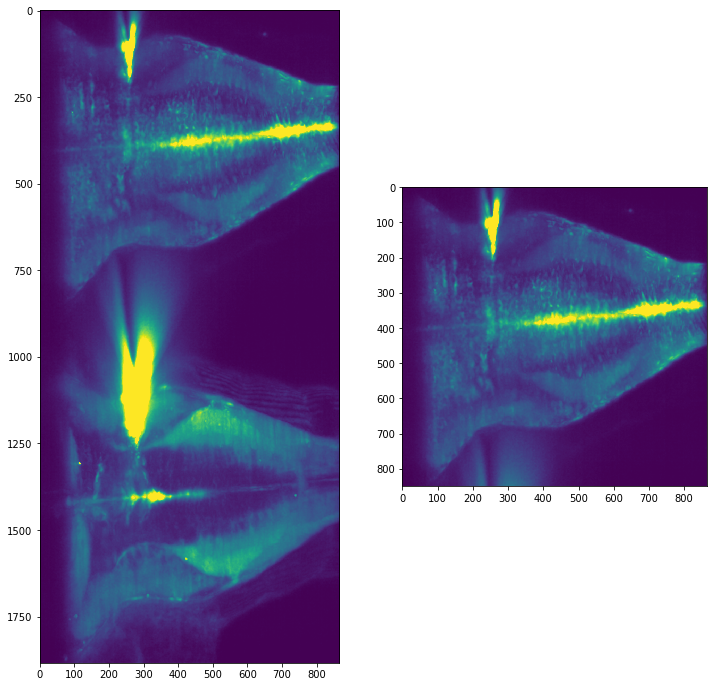

In [52]:
if shifts is None:
    reg_roi = (slice(None), slice(None), slice(850), slice(None))
    fig, axs = plt.subplots(ncols=2, figsize=(12,12))
    axs[0].imshow(anat_ref.max(0).squeeze(), clim=(100,200))
    axs[1].imshow(anat_ref[reg_roi[1:]].max(0).squeeze(), clim=(100,200))

In [53]:
%%time
if shifts is None:
    cluster.start_workers(300)
    ref_mx_bc = client.scatter(anat_ref[reg_roi[1:]].max(0), broadcast=True)
    data_filt = data[reg_roi].astype('float32').map_blocks(lambda v: median_filter(v, (1,1,5,5)), dtype='float32')
    affines = da.map_blocks(reg, ref_mx_bc, data_filt.max(1), dtype='float32', chunks=(1,2,2)).compute()    
    np.save(reg_path, affines)
    shifts = -affines[:,:-1,-1]
    cluster.stop_all_jobs()

CPU times: user 1min 49s, sys: 26.3 s, total: 2min 16s
Wall time: 4min 8s


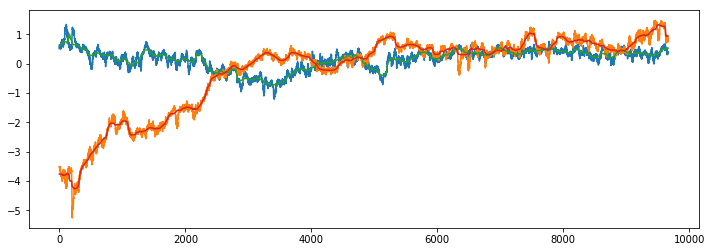

In [54]:
fig, axs = plt.subplots(figsize=(12,4))
axs.plot(shifts)
shifts_filt = median_filter(shifts, size=(150,1))
axs.plot(shifts_filt)

In [55]:
%%time
cluster.start_workers(10)
time.sleep(10)
shifts_filt_bc = client.scatter(shifts_filt)
medfilt = partial(median_filter, size=(1,1,3,3))
data_filt = data.astype('float32').map_blocks(medfilt, dtype='float32')
data_tx = data_filt.map_blocks(shift_yx, shifts_filt_bc, dtype='float32')

ds_xy = 4
data_ds = coarsen(np.mean, data_tx, {2: ds_xy, 3: ds_xy})
rechunked = data_ds.rechunk(chunks=(data_ds.shape[0], 'auto', 'auto','auto'))
data_dff = rechunked.map_blocks(mydff, dtype='float32')

CPU times: user 1.55 s, sys: 671 ms, total: 2.22 s
Wall time: 11.7 s


In [ ]:
%%time
cluster.start_workers(100)
result = data_dff.compute().squeeze()
time.sleep(10)
cluster.stop_all_jobs()

In [57]:
%%time
out_fname = f'{reg_dir}{exp_name}_dff_ds{ds_xy}.tif'
imsave(out_fname, result, imagej=True)

CPU times: user 1min 4s, sys: 41.7 s, total: 1min 46s
Wall time: 1min 53s


/groups/ahrens/home/bennettd/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1088: UserWarning: truncating ImageJ file
  warnings.warn("truncating ImageJ file")


In [59]:
result.shape

(9667, 10, 471, 216)

In [64]:
import flika as flk
flk.start_flika()
win = flk.window.Window(result[:,8])

Starting flika
flika menubar already initialized.
Starting flika inside IPython


In [ ]:
m = win.rois[0].getMask()

In [ ]:
roits = [result.transpose(1,2,0)[r.getMask()].mean(0) for r in win.rois]

In [ ]:
fig, axs = plt.subplots(dpi=100, figsize=(12,4))
x = np.arange(data.shape[0])/ fs_im
axs.plot(x, roits[1], label='Opto stim', color='c')
axs.plot(x, roits[0], label='LH astroglia', color='g')
axs.legend()